# PyMca XAS data processing

PyMca is a spectroscopy library from python: https://github.com/vasole/pymca

## Example EXAFS spectrum

Example EXFAS spectrum


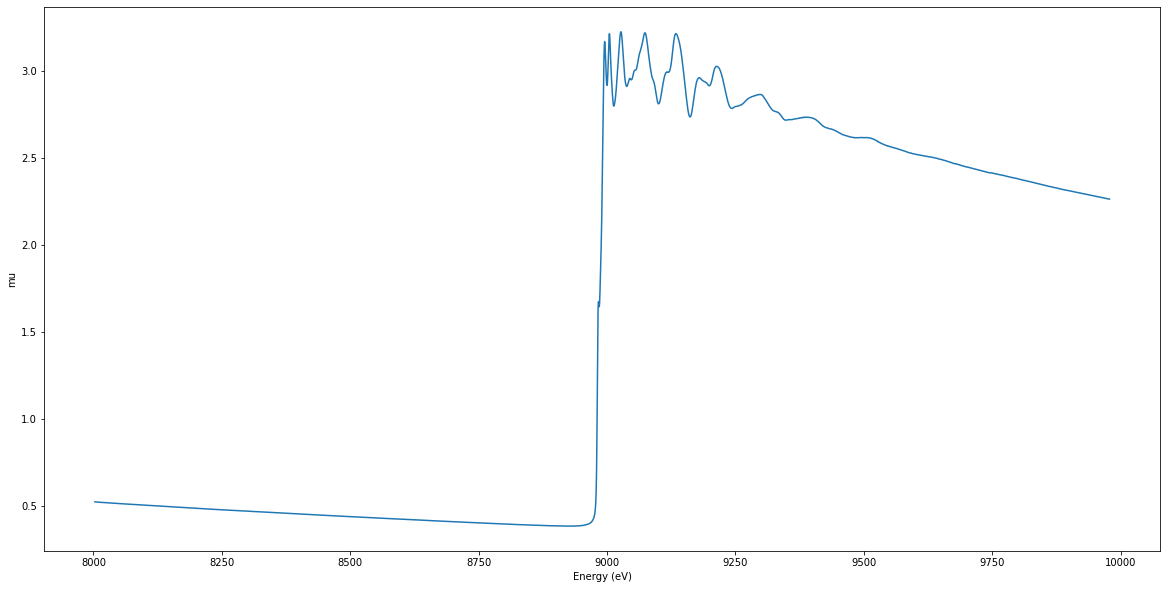

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from est.tests.data import example_spectrum
from est.resources import resource_path

filename = str(resource_path("exafs/EXAFS_Cu.dat"))
energy, mu = example_spectrum("exafs/EXAFS_Cu.dat")

plt.figure(figsize=(20, 10))
plt.plot(energy, mu)
plt.xlabel("Energy (eV)")
plt.ylabel("mu")

print("Example EXFAS spectrum")

## Import data

The main class dealing with XAS data in *pymca* is the `XASClass`

In [2]:
from PyMca5.PyMcaPhysics.xas.XASClass import XASClass

pymca_xas = XASClass()
pymca_xas.setSpectrum(energy, mu)

In *est* the main class is `XASObject`

In [3]:
from est.core.io import read_from_url
from est.io.utils.ascii import build_ascii_data_url

xas_data = read_from_url(
    spectra_url=build_ascii_data_url(
        file_path=filename,
        col_name="Column 2",
    ),
    channel_url=build_ascii_data_url(
        file_path=filename,
        col_name="Column 1",
    ),
    dimensions=(2, 1, 0),
)

### Normalization

Pre-edge and post-edge fitting and normalization


$$
\mu_{\mathrm{norm}}(E) = \frac{\mu(E)-\mathrm{pre}(E)}{\mathrm{post}(E)-\mathrm{pre}(E)}
$$

['Jump', 'JumpNormalizationMethod', 'Edge', 'NormalizedEnergy', 'NormalizedMu', 'NormalizedBackground', 'NormalizedSignal', 'NormalizedPlotMin', 'NormalizedPlotMax']


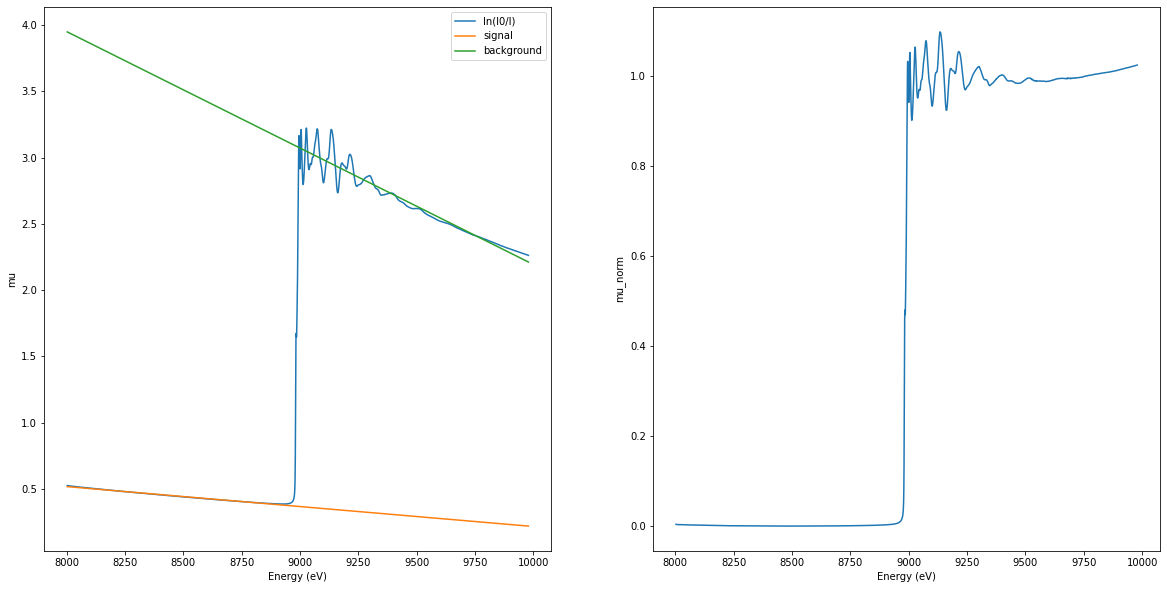

In [4]:
norm_pymca = pymca_xas.normalize()

ax1, ax2 = plt.subplots(1, 2, figsize=(20, 10))[-1]

ax1.plot(energy, mu, label="ln(I0/I)")
ax1.plot(
    norm_pymca["NormalizedEnergy"], norm_pymca["NormalizedBackground"], label="signal"
)
ax1.plot(
    norm_pymca["NormalizedEnergy"], norm_pymca["NormalizedSignal"], label="background"
)
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("mu")
ax1.legend()

ax2.plot(norm_pymca["NormalizedEnergy"], norm_pymca["NormalizedMu"])
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("mu_norm")

print(list(norm_pymca))

[est.core.types.spectra] INFO : fail to access to NormalizedEnergy
[est.core.types.spectra] INFO : fail to access to NormalizedEnergy
[est.core.types.spectra] INFO : fail to access to NormalizedMu
[est.core.types.spectra] INFO : fail to access to NormalizedMu
[est.core.types.spectra] INFO : fail to access to NormalizedSignal
[est.core.types.spectra] INFO : fail to access to NormalizedSignal
[est.io.io] WARNING : Unable to write at results/NormalizedEnergy reason is One of data, shape or dtype must be specified
[est.io.io] WARNING : Unable to write at results/NormalizedMu reason is One of data, shape or dtype must be specified
[est.io.io] WARNING : Unable to write at results/NormalizedSignal reason is One of data, shape or dtype must be specified
[matplotlib.legend] WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'mu_norm')

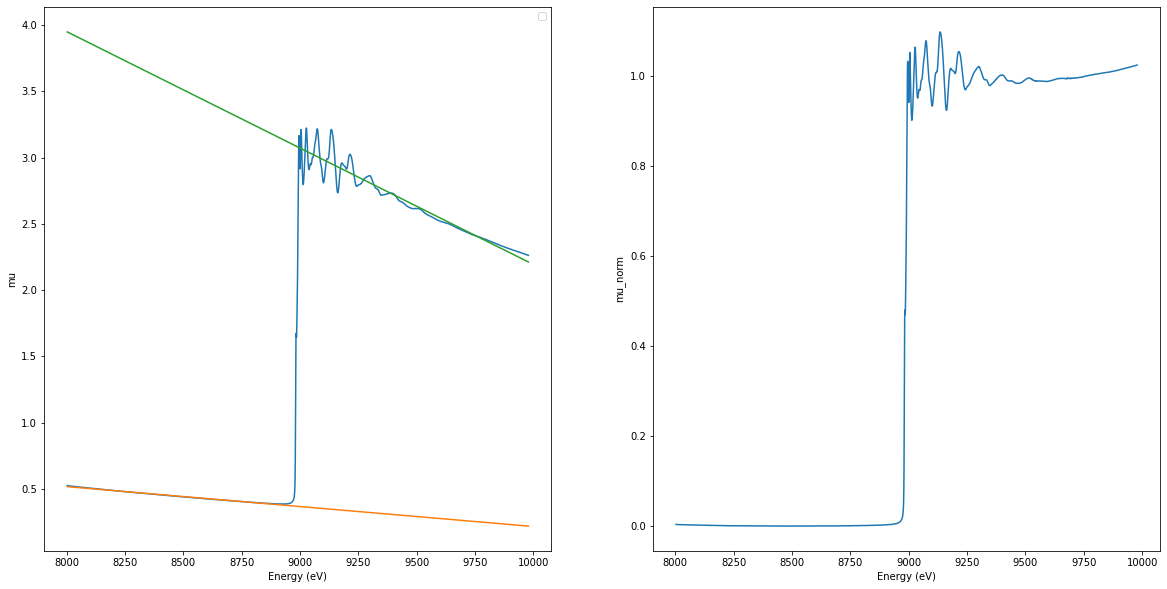

In [5]:
from est.core.process.pymca.normalization import pymca_normalization

xas_norm = pymca_normalization(xas_data.copy())
norm_est = xas_norm.spectra.data.flatten()[0]

ax1, ax2 = plt.subplots(1, 2, figsize=(20, 10))[-1]

ax1.plot(energy, mu)
ax1.plot(norm_est.normalized_energy, norm_est.pre_edge)
ax1.plot(norm_est.normalized_energy, norm_est.post_edge)
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("mu")
ax1.legend()

ax2.plot(norm_est.normalized_energy, norm_est.normalized_mu)
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("mu_norm")

## EXAFS signal

$$
\chi(k) = \frac{\mu_{\mathrm{norm}}(k) - \mu_0(k)}{\mu_0(k)}
$$

$$
k = \frac{\sqrt{2m(E-E_0)}}{\hbar^2}
$$

[PyMca5.PyMcaPhysics.xas.XASClass] WARNING : Error: dimension of knots must be dimension of polDegree+1
[PyMca5.PyMcaPhysics.xas.XASClass] WARNING :        Forced automatic (equidistant) knot definition.


['PostEdgeK', 'PostEdgeB', 'KnotsX', 'KnotsY', 'KMin', 'KMax', 'KWeight']


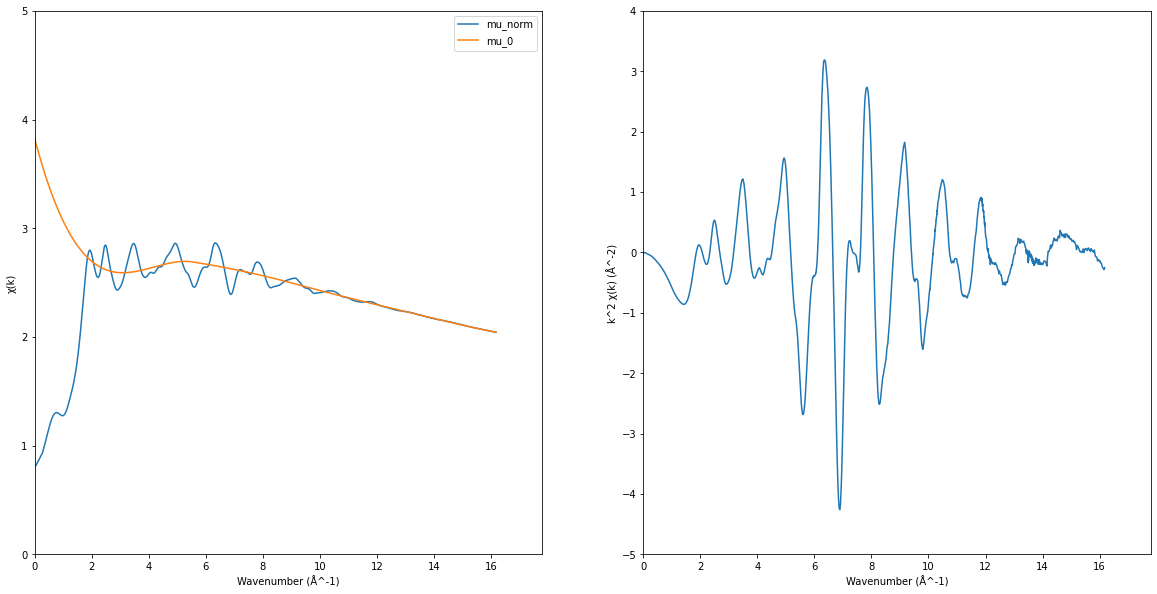

In [6]:
from PyMca5.PyMcaPhysics.xas.XASClass import e2k

k = e2k(energy - norm_pymca["Edge"])
# norm_mu = norm_est["NormalizedMu"]
norm_mu = mu - norm_est.pre_edge

exafs_pymca = pymca_xas.postEdge(k=k, mu=norm_mu)

ax1, ax2 = plt.subplots(1, 2, figsize=(20, 10))[-1]

ax1.plot(k, norm_mu, label="mu_norm")
ax1.plot(k, exafs_pymca["PostEdgeB"], label="mu_0")
ax1.set_xlim(0, None)
ax1.set_ylim(0, 5)

ax1.set_xlabel("Wavenumber (Å^-1)")
ax1.set_ylabel("χ(k)")
ax1.legend()

chi = (norm_mu - exafs_pymca["PostEdgeB"]) / exafs_pymca["PostEdgeB"]
exafs = chi * k**2
ax2.plot(k, exafs)
ax2.set_xlabel("Wavenumber (Å^-1)")
ax2.set_ylabel("k^2 χ(k) (Å^-2)")
ax2.set_xlim(0, None)
ax2.set_ylim(-5, 4)

print(list(exafs_pymca))

[PyMca5.PyMcaPhysics.xas.XASClass] WARNING : Error: dimension of knots must be dimension of polDegree+1
[PyMca5.PyMcaPhysics.xas.XASClass] WARNING :        Forced automatic (equidistant) knot definition.


exafs: [####################] 100% DONE


[est.core.types.spectra] INFO : fail to access to EXAFSKValues
[est.core.types.spectra] INFO : fail to access to EXAFSKValues
[est.core.types.spectra] INFO : fail to access to EXAFSSignal
[est.core.types.spectra] INFO : fail to access to EXAFSSignal
[est.io.io] WARNING : Unable to write at results/EXAFSKValues reason is One of data, shape or dtype must be specified
[est.io.io] WARNING : Unable to write at results/EXAFSSignal reason is One of data, shape or dtype must be specified


(-5.0, 4.0)

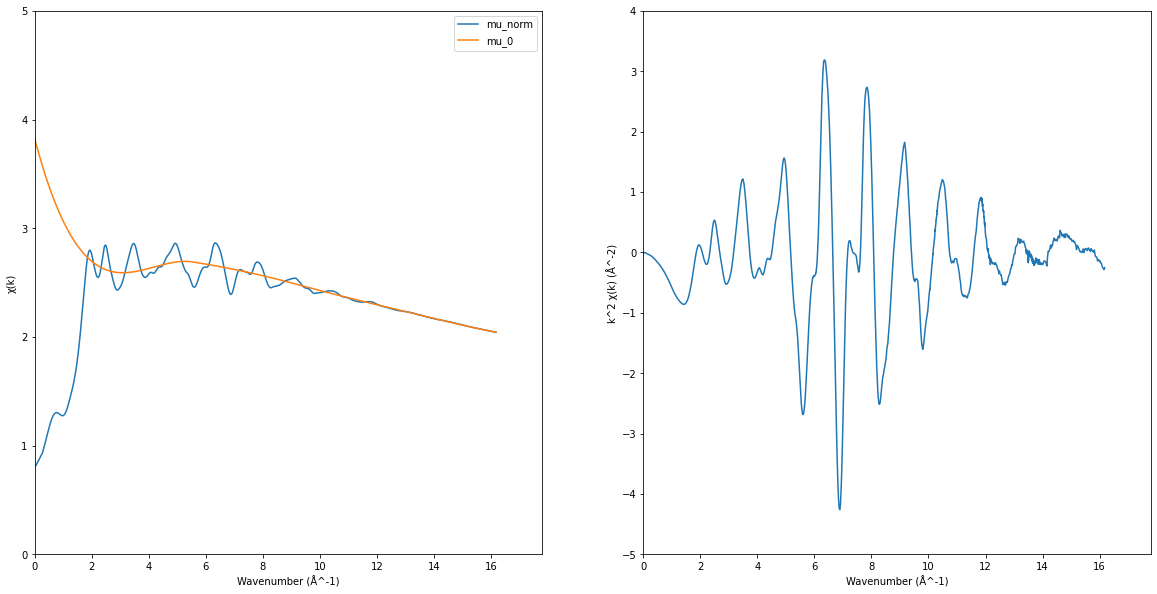

In [7]:
from est.core.process.pymca.exafs import pymca_exafs

xas_exafs = pymca_exafs(xas_norm.copy(), exafs={"KWeight": 2})
exafs_est = xas_exafs.spectra.data.flatten()[0]

ax1, ax2 = plt.subplots(1, 2, figsize=(20, 10))[-1]

ax1.plot(exafs_est.k, exafs_est.chi, label="mu_norm")
ax1.plot(exafs_est.k, exafs_est.pymca_dict["PostEdgeB"], label="mu_0")
ax1.set_xlim(0, None)
ax1.set_ylim(0, 5)

ax1.set_xlabel("Wavenumber (Å^-1)")
ax1.set_ylabel("χ(k)")
ax1.legend()

ax2.plot(exafs_est.k, exafs_est.pymca_dict["EXAFSNormalized"])
ax2.set_xlabel("Wavenumber (Å^-1)")
ax2.set_ylabel("k^2 χ(k) (Å^-2)")
ax2.set_xlim(0, None)
ax2.set_ylim(-5, 4)

### Fourier transform

$$
\mathrm{ft}(R) = \mathrm{FFT}(k^2\chi(k)w(k))
$$

['Set', 'InterpolatedK', 'InterpolatedSignal', 'KWeight', 'K', 'WindowWeight', 'FTRadius', 'FTIntensity', 'FTReal', 'FTImaginary']


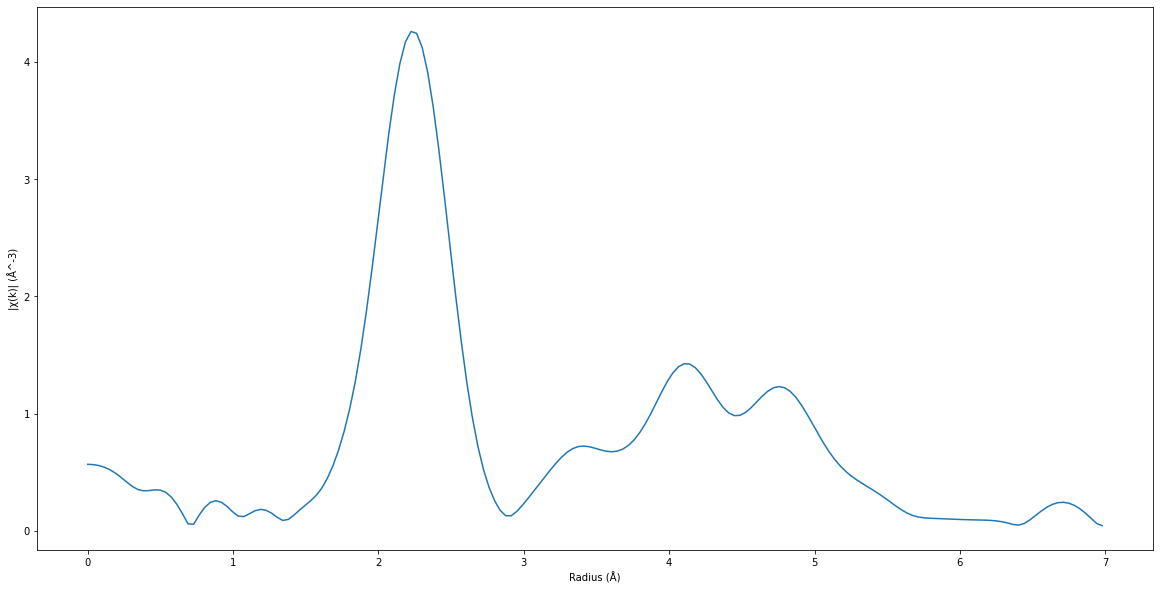

In [8]:
spectrum = xas_exafs.spectra.data.flatten()[0]

ft_pymca = pymca_xas.fourierTransform(
    k=k, mu=exafs, kMin=spectrum.pymca_dict["KMin"], kMax=spectrum.pymca_dict["KMax"]
)

plt.figure(figsize=(20, 10))
plt.plot(ft_pymca["FTRadius"], ft_pymca["FTIntensity"])
plt.xlabel("Radius (Å)")
plt.ylabel("|χ(k)| (Å^-3)")

print(list(ft_pymca))

ft: [####################] 100% DONE


Text(0, 0.5, '|χ(k)| (Å^-3)')

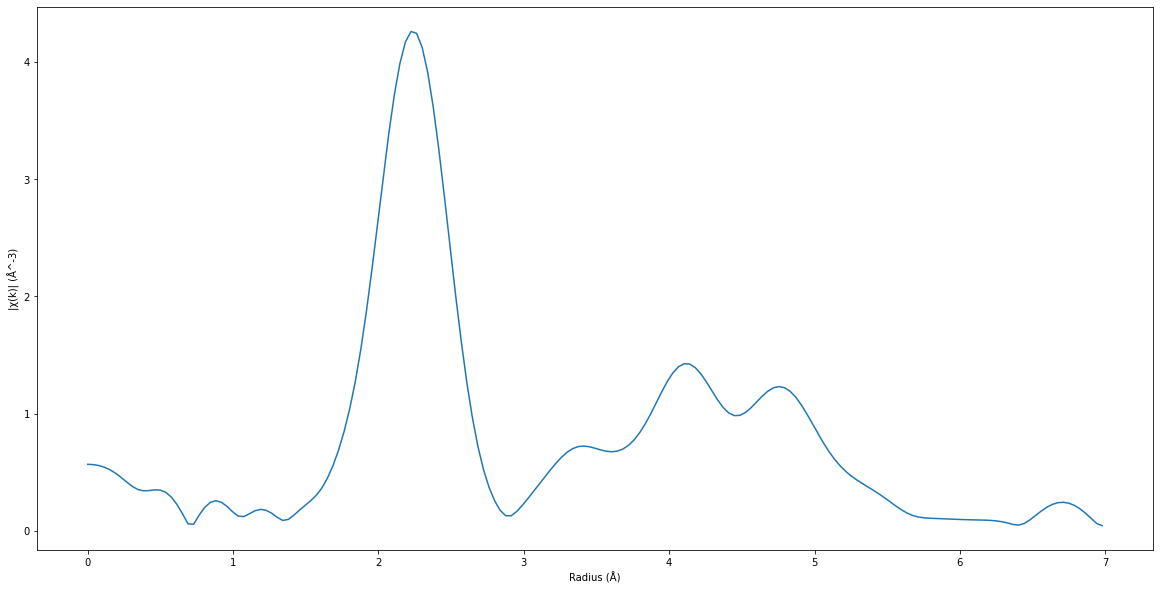

In [9]:
from est.core.process.pymca.ft import pymca_ft

xas_ft = pymca_ft(xas_exafs.copy())
ft_est = xas_ft.spectra.data.flatten()[0]

plt.figure(figsize=(20, 10))
plt.plot(ft_est.ft["FTRadius"], ft_est.ft["FTIntensity"])
plt.xlabel("Radius (Å)")
plt.ylabel("|χ(k)| (Å^-3)")